In [ ]:
!nvidia-smi

Tue Nov  3 02:30:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* @file 深度學習基礎 / model_tunning.ipynb
  * @brief model_tunning 模型實作 

  * 此份程式碼是以教學為目的，附有完整的架構解說。

  * @author 人工智慧科技基金會 AI 工程師 - 康文瑋
  * Email: run963741@aif.tw
  * Resume: https://www.cakeresume.com/run963741

  * 最後更新日期: 2020/11/26

# Model tuning

當模型的效果不佳時，可以嘗試調整以下模型參數架構: 

* 學習率 `Learning rate`
* 激發函數 `Activation function`
* 優化器 `Optimizer`

## 載入函數

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

# 模擬資料集

In [ ]:
def linear_model(rseed=222, n_samples=30):
    " Generate data according to a linear model"
    np.random.seed(rseed)

    data = np.random.normal(-1, 1, (n_samples, 2))
    data[:n_samples // 2] -= 1.5
    data[n_samples // 2:] += 1.5

    labels = np.ones(n_samples)
    labels[:n_samples // 2] = 0

    return data, labels

## 產生資料集

In [ ]:
n_samples = 2000
X, y = linear_model(n_samples = n_samples)

# 將標籤 y 做 One-hot encoding
y = tf.keras.utils.to_categorical(y)

In [ ]:
print('X: ', X[:5])
print('y: ', y[:5])

X:  [[-0.53657498 -2.22423031]
 [-2.0413418  -1.49873534]
 [-3.26383531 -1.77807234]
 [-3.40546956 -1.49812661]
 [-3.02074247 -2.19104713]]
y:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### 資料視覺化

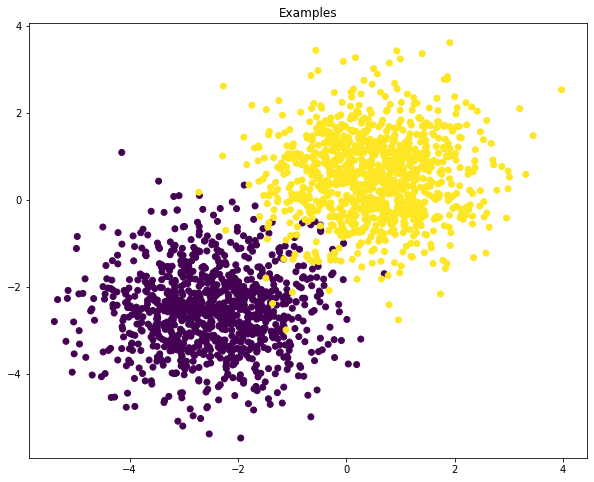

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c = y[:,1])
plt.title('Examples')
plt.show()

## 切割訓練集 (Training set) 以及測試集 (testing set)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

print('Training data size: ', X_train.shape)
print('Testing data size: ', X_test.shape)

Training data size:  (1200, 2)
Testing data size:  (800, 2)


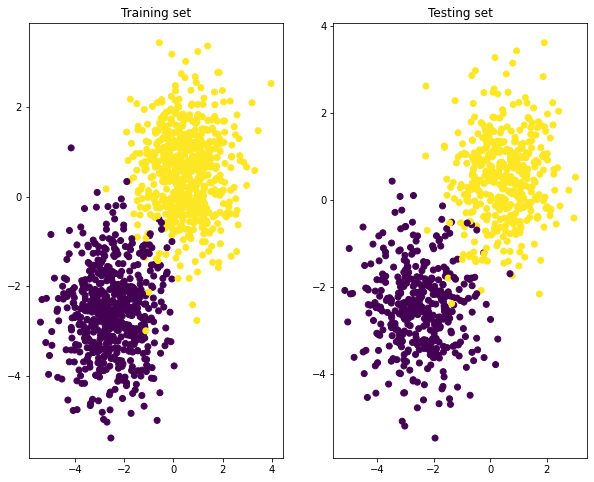

In [ ]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], c = y_train[:,1])
plt.title('Training set')

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:,1], c = y_test[:,1])
plt.title('Testing set')
plt.show()

## 建立模型

In [ ]:
def build_model(activation):

  input = tf.keras.layers.Input(shape=(2,), name='Input_layer')
  dense1 = tf.keras.layers.Dense(32, activation=activation, name='dense1')(input)
  dense2 = tf.keras.layers.Dense(64, activation=activation, name='dense2')(dense1)
  dense3 = tf.keras.layers.Dense(128, activation=activation, name='dense3')(dense2)
  dense4 = tf.keras.layers.Dense(64, activation=activation, name='dense4')(dense3)
  output = tf.keras.layers.Dense(2, activation='softmax', name='Output_layer')(dense4)

  model = tf.keras.Model(input, output)

  return model

In [ ]:
model = build_model(activation='relu')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 32)                96        
_________________________________________________________________
dense2 (Dense)               (None, 64)                2112      
_________________________________________________________________
dense3 (Dense)               (None, 128)               8320      
_________________________________________________________________
dense4 (Dense)               (None, 64)                8256      
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 130       
Total params: 18,914
Trainable params: 18,914
Non-trainable params: 0
__________________________________________________

# Learning rate

學習率指的是梯度下降公式中的 $\color{red}{\eta}$，$\color{red}{\eta}$ 的大小影響了模型收斂的效率，如下圖：

* Too low: 如最左圖，若學習率太小，模型收斂速度緩慢，導致必須使用比較大的 `Epoch` 才能達到收斂。

* Just right: 如中圖，若學習率適中，模型的收斂速度會比較正常。
* Too high: 如右圖，若學習率過大，則容易在最佳解附近震盪，會發現損失函數值跳來跳去，無法順利下降。

從經驗來說，學習率通常會介於 `0` 至 `1` 之間，並以 `10` 的倍數來調整，例如 `1e-2`,`1e-3`,`1e-4`等等。

$$
\hat{\theta}:=\theta- \color{red}{\eta}\frac{\partial C}{\partial\theta}
$$

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1qeZYR81tN7Y7EiJYHJs4LyDndqXrWPQa' width="700"/>
<figcaption></figcaption></center>
</figure>

### 訓練模型

In [ ]:
# 以下放置要比較的 learning rate
lr_list = [0.1, 1e-2, 1e-3, 1e-4]

batch_size = 16
epochs = 50

# 建立兩個 list 記錄選用不同 learning rate 的訓練結果
all_loss, all_acc = [], []

# 迭代不同的 learning rate 去訓練模型
for lr in lr_list:
    print("Running model, learning rate = {}".format(lr))

    # 確保每次都是訓練新的模型，而不是接續上一輪的模型
    model = build_model(activation='relu')
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=lr),
                  metrics=['accuracy'])

    # 確保每次都設定一樣的參數
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        shuffle=True,
                        validation_data=(X_test, y_test))

    # 將訓練過程記錄下來
    all_loss.append(history.history['loss'])
    all_acc.append(history.history['accuracy'])
print('----------------- training done! -----------------')

Running model, learning rate = 0.1
Running model, learning rate = 0.01
Running model, learning rate = 0.001
Running model, learning rate = 0.0001
----------------- training done! -----------------


### 視覺化訓練結果

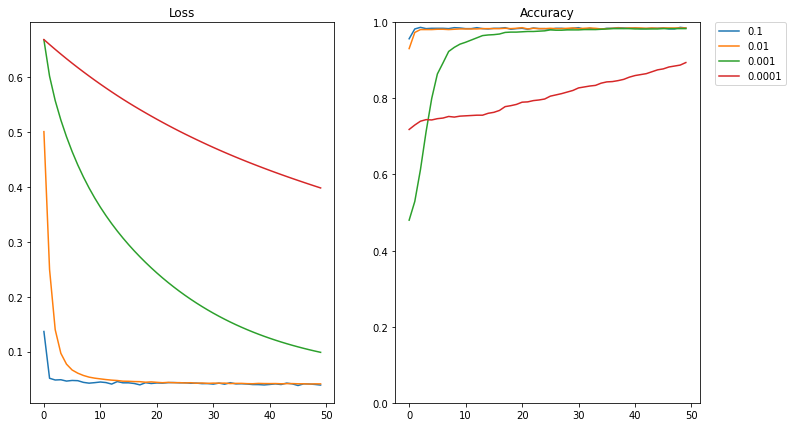

In [ ]:
# 視覺化訓練過程
plt.figure(figsize=(12, 7))

# 繪製 Training loss
plt.subplot(121)
for k in range(len(lr_list)):
    plt.plot(range(len(all_loss[k])), all_loss[k], label=lr_list[k])
plt.title('Loss')

# 繪製 Training accuracy
plt.subplot(122)
for k in range(len(lr_list)):
    plt.plot(range(len(all_acc[k])), all_acc[k], label=lr_list[k])
plt.title('Accuracy')

plt.ylim((0, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Activation function

激活函數最主要的目標在於確保模型去學習非線性的能力，生活中幾乎所有的資料都一定有非線性的性質，也就是無法用一條直線、平面或是高維的平面來劃分，在邊界上都是彎彎曲曲的樣子，這時就需要激發函數的非線性性質，詳細的教學請參考 `DL_part1/3_non_linear_function.ipynb`。

比較常見的激活函數如下圖，在早期比較常用的為 `sigmoid`，但是當模型層數一深的時候，`sigmoid` 會引發 **梯度消失** 的問題，所以後來就鮮少人使用，目前最常用且效果也普遍較好的激發函數為 `relu`，其優點就是計算快速，只需要簡單計算 $max(0,x)$ 即可，近期還有如 `mish` 這種比較新穎的激發函數可以使用。

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1HwbxwZIiWapLOIZ3DhZr1O18H2uBXW58' width="700"/>
<figcaption>Activation function</figcaption></center>
</figure>

如下圖，[`Mish`](https://arxiv.org/abs/1908.08681) 是 2019 年提出的激發函數，這個函數比起 `relu` 來說，在 `x` 為負的地方更加平滑，不會像 `relu` 會出現斷層的現象，下下圖中顯示在某一層中， `relu` 和 `Mish` 的梯度分佈，`relu` 的梯度會類似斷層的現象，這會導致模型在學習過程中梯度不穩定，導致收斂效果不彰，而 `Mish` 看起來比較平滑，而這種平滑的特性對於模型來說比較健康。

$$
Mish(x) = x\tanh(\log(1+e^x))
$$

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=11uPrZXqR3DX_4hp7Da2gg1GHv0sxTQe2' width="700"/>
<figcaption>Mish activation function</figcaption></center>
</figure>

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1RskrMHYzVkzz83NLkReJgUHCbqWwwf4S' width="700"/>
<figcaption>Gradient distribution between relu and mish</figcaption></center>
</figure>


### 訓練模型

In [ ]:
# Tensorflow 支援的激發函數可參考 https://www.tensorflow.org/api_docs/python/tf/keras/activations
# mish 目前還沒有支援，可以自己客製化激發函數
def mish(x):
	return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.math.log(1+tf.math.exp(x))))(x)

In [ ]:
# 以下放置要比較的 activation function
acti_list = ['sigmoid', 'tanh', 'softplus', 'relu', mish]

batch_size = 16
epochs = 20

# 建立兩個 list 記錄選用不同 activation function 的訓練結果
all_loss, all_acc = [], []

# 迭代不同的 activation function 去訓練模型
for acti in acti_list:
    if isinstance(acti, str) :
      print("Running model, activation function = {}".format(acti))
    else:
      print("Running model, activation function = mish")

    # 確保每次都是訓練新的模型，而不是接續上一輪的模型
    model = build_model(activation=acti)
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])

    # 確保每次都設定一樣的參數
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        shuffle=True,
                        validation_data=(X_test, y_test))

    # 將訓練過程記錄下來
    all_loss.append(history.history['loss'])
    all_acc.append(history.history['accuracy'])
print('----------------- training done! -----------------')

Running model, activation function = sigmoid
Running model, activation function = tanh
Running model, activation function = softplus
Running model, activation function = relu
Running model, activation function = mish
----------------- training done! -----------------


### 視覺化訓練結果

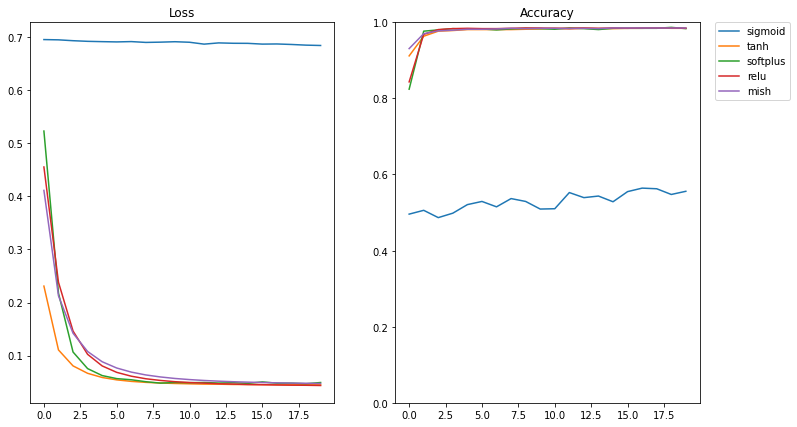

In [ ]:
acti_list = ['sigmoid', 'tanh', 'softplus', 'relu', 'mish']

# 視覺化訓練過程
plt.figure(figsize=(12, 7))

# 繪製 Training loss
plt.subplot(121)
for k in range(len(acti_list)):
    plt.plot(range(len(all_loss[k])), all_loss[k], label=acti_list[k])
plt.title('Loss')

# 繪製 Training accuracy
plt.subplot(122)
for k in range(len(acti_list)):
    plt.plot(range(len(all_acc[k])), all_acc[k], label=acti_list[k])
plt.title('Accuracy')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.ylim((0, 1))
plt.show()

# Optimizer

優化器在深度學習中是負責決定梯度如何更新，在前幾章節所使用的優化器都是 `SGD (Stochastic Gradient Descent)`，這種做法是每次迭代時從資料中隨機拿一筆資料丟給模型預測，接著計算完 loss 之後進行梯度更新，後來才發展成每次隨機拿 `batch_size` 筆的資料來輸入給模型，每次拿 `batch_size` 筆的優點在於可以將資料中的變異抹平：

$$
\hat{\theta}=\theta-\eta\frac{\partial C}{\partial\theta}
$$

後來又陸續有許多新穎的優化器發展出來，最終目標都是為了有效的利用梯度，目前最常使用的優化器是 `RMSprop`, `Adam` 以及 `ranger`。

In [ ]:
import tensorflow_addons as tfa

### 訓練模型

In [ ]:
# 以下放置要比較的 optimizer
optim_list = ['SGD', 'Adagrad', 'RMSprop', 'Adam', 'ranger']

batch_size = 32
epochs = 100

# 建立兩個 list 記錄選用不同 optimizer 的訓練結果
all_loss, all_acc = [], []

# 迭代不同的 optimizer 去訓練模型
for optim in optim_list:
    print("Running model, optimizer = {}".format(optim))

    # 確保每次都是訓練新的模型，而不是接續上一輪的模型
    model = build_model(activation = 'relu')
    if optim == "SGD":
        optim = tf.keras.optimizers.SGD(lr=0.01)
    elif optim == "Adagrad":
        optim = tf.keras.optimizers.Adagrad(lr=0.001)
    elif optim == "RMSprop":
        optim = tf.keras.optimizers.RMSprop(lr=0.001)
    elif optim == "Adam":
        optim = tf.keras.optimizers.Adam(lr=0.001)
    elif optim == 'ranger': # 目前 ranger 還未正式加入 tensorflow 裡面，必須使用額外的套件 tensorflow_addons 來載入
        radam = tfa.optimizers.RectifiedAdam()
        optim = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

    # 確保每次都設定一樣的參數
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        shuffle=True,
                        validation_data=(X_test, y_test))

    # 將訓練結果記錄下來
    all_loss.append(history.history['loss'])
    all_acc.append(history.history['accuracy'])
print('----------------- training done! -----------------')

Running model, optimizer = SGD
Running model, optimizer = Adagrad
Running model, optimizer = RMSprop
Running model, optimizer = Adam
Running model, optimizer = ranger
----------------- training done! -----------------


### 視覺化訓練結果

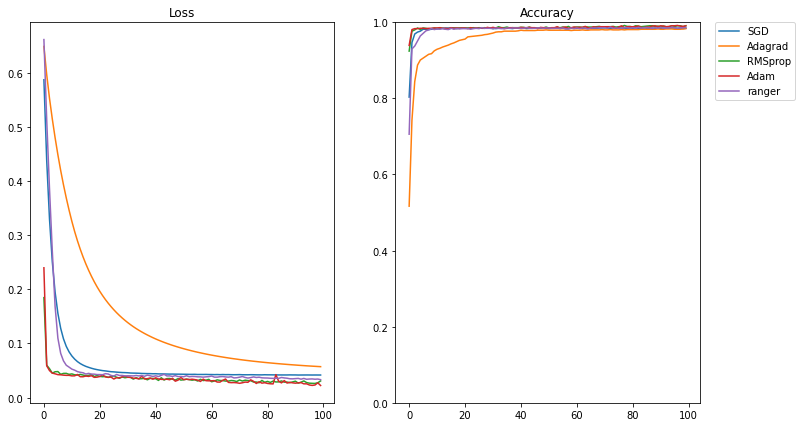

In [ ]:
# 視覺化訓練過程
plt.figure(figsize=(12, 7))

# 繪製 Training loss
plt.subplot(121)
for k in range(len(optim_list)):
    plt.plot(range(len(all_loss[k])), all_loss[k], label=optim_list[k])
plt.title('Loss')

# 繪製 Training accuracy
plt.subplot(122)
for k in range(len(optim_list)):
    plt.plot(range(len(all_acc[k])), all_acc[k], label=optim_list[k])
plt.title('Accuracy')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0, 1))
plt.show()